# Compare Time Domain Survey and VASCA catalogs

### Setup main notebook options

In [1]:
region_name = "TDS"  #_ELAISN1
redo_src_sel = False  # Redo source selection in dedicated cell below

### Load VASCA region

In [2]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
from vasca.utils import sel_sources
import vasca.visualization as vvis

#Load region
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

#Apply source selections
sel_vasca =  sel_sources(rg.tt_sources)
if redo_src_sel:
    rg.tt_sources["sel"][:]=sel_vasca   
else:
    sel_vasca = rg.tt_sources["sel"]
tt_vasca = rg.tt_sources[sel_vasca]

field_id,field_name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes32,bytes32,float64,float64,bytes22,bytes8,float32,bool,int32,float32,float64,float64,int64
GNU2592597978464124928,PS_XMMLSS_MOS00,35.578863351058885,-3.14176421214975,GALEX,NUV,1.2,True,27,40457.25,54791.262777777774,57213.3405928096,1
GNU2592668347208302592,PS_XMMLSS_MOS01,36.49984981667359,-3.4923125504146,GALEX,NUV,1.2,True,26,38608.996,54791.33122685185,57205.55893265336,2
GNU2592738715952480256,PS_XMMLSS_MOS02,34.995648096666685,-3.95320684099725,GALEX,NUV,1.2,True,24,23118.55,54791.399976851855,56670.07746654369,3
GNU2592809084696657920,PS_XMMLSS_MOS03,35.87152971805409,-4.25258328683038,GALEX,NUV,1.2,True,21,31699.102,54791.468136574076,57205.5459979022,4
GNU2592879453440835584,PS_XMMLSS_MOS04,36.890941423843685,-4.42319486511272,GALEX,NUV,1.2,True,23,34784.05,54791.53658564815,57214.614389105904,5
GNU2592949822185013248,PS_XMMLSS_MOS05,35.19163328261652,-5.0517494636978,GALEX,NUV,1.2,True,22,32845.8,54791.60503472222,57205.68289605035,6
GNU2593020190929190912,PS_XMMLSS_MOS06,36.220702772470815,-5.20539528501055,GALEX,NUV,1.2,True,23,33876.6,54791.673472222225,57206.85126283999,7
GNU2593653509626789888,PS_CDFS_MOS00,53.10325584718021,-27.796382607231,GALEX,NUV,1.2,True,117,185705.4,54812.34815972222,56994.373020833336,8


### Get TDS & VASCA data and match them positionally

In [3]:
print(f"Selected {len(tt_vasca)} out of {len(rg.tt_sources)} sources")

#Read TDS
tt_tds_all = Table.read("./resources/TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
tt_tds = tt_tds_all
if "ELAISN1" in region_fname:    # restrict t ELAISN1 fields?
    tt_tds = tt_tds_all[sel_elai]
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")

match_dist = 10 * uu.arcsec
idx_tds, dist_tds, _ = pos_vasca.match_to_catalog_sky(pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds.to("arcsec")
tt_vasca["tds_match"] = tt_vasca["tds_dist"] < match_dist

idx_vasca, dist_vasca, _ = pos_tds.match_to_catalog_sky(pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca.to("arcsec")
tt_tds["vasca_match"] = tt_tds["vasca_dist"] < match_dist

#display("Selected rg_src_ids",tt_vasca[:]["rg_src_id"].data)
#display(tt_tds[:2])

sel_tmv = tt_tds["vasca_match"]
sel_vmt = tt_vasca["tds_match"]
print("Nr. sources VASCA/TDS :",len(tt_vasca),"/",len(tt_tds))
print("Nr. associated sources VASCA/TDS:",sel_vmt.sum(),"/",sel_tmv.sum())
print("Fraction of associated VASCA/TDS sources:",sel_vmt.sum()/len(tt_vasca),"/",sel_tmv.sum()/len(tt_tds))

Selected 1030 out of 123024 sources
Nr. sources VASCA/TDS : 1030 / 1078
Nr. associated sources VASCA/TDS: 505 / 508
Fraction of associated VASCA/TDS sources: 0.49029126213592233 / 0.4712430426716141


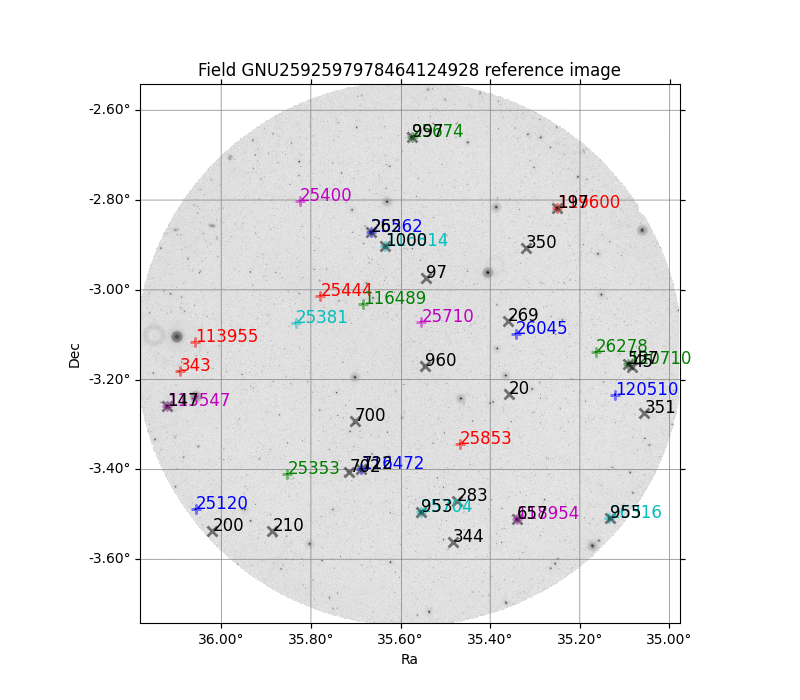

In [4]:
#PS_ELAISN1_MOS15 is field_id GNU2597664528044916736 (TDE PS1-10jh field)
field_id = rg.tt_fields["field_id"][0]
fd = rg.get_field(field_id=field_id, load_method="FITS", add_field=False)

fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, src_id="rg_src_id", sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

plot_tds = {"marker":"x","color":"k"}
ax = vvis.plot_sky_sources(tt_tds, src_id="recno",src_kwargs=plot_tds, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))